# MNIST TUTORIAL

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.




[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


nohup eva_server >> eva.log 2>&1 &
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF FastRCNNObjectDetector already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF ArrayCount already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Timestamp already exists, nothing added.\n')
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Crop already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF YoloV5 already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Open already exists, nothing added.\n')
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Similarity already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


### Downloading the videos

In [2]:
# Getting MNIST as a video
!wget -nc https://www.dropbox.com/s/yxljxz6zxoqu54v/mnist.mp4
# Getting a udf
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/apps/mnist/eva_mnist_udf.py

File ‘mnist.mp4’ already there; not retrieving.



File ‘eva_mnist_udf.py’ already there; not retrieving.



### Upload the video for analysis

In [3]:
cursor.execute('DROP TABLE MNISTVid')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "mnist.mp4" INTO MNISTVid')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MNISTVid
@query_time: 0.05475105531513691


@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.08349510282278061


### Visualize Video

In [4]:
from IPython.display import Video
Video("mnist.mp4", embed=True)

### Create an user-defined function (UDF) for analyzing the frames

In [5]:
cursor.execute("""CREATE UDF IF NOT EXISTS MnistCNN 
                  INPUT  (data NDARRAY (3, 28, 28))
                  OUTPUT (label TEXT(2))
                  TYPE  Classification
                  IMPL  'eva_mnist_udf.py'
        """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                              0
0  UDF MnistCNN already exists, nothing added.
@query_time: 0.013865657150745392


### Run the Image Classification UDF on video

In [6]:
cursor.execute("""SELECT data, MnistCNN(data).label 
                  FROM MNISTVid
                  WHERE id = 30 OR id = 50 OR id = 70 OR id = 0 OR id = 140""")
response = cursor.fetch_all()
print(response.as_df())

                                       mnistvid.data mnistcnn.label
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...              6
1  [[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...              2
2  [[[13, 13, 13], [2, 2, 2], [2, 2, 2], [13, 13,...              3
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...              7
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...              5


### Visualize output of query on the video

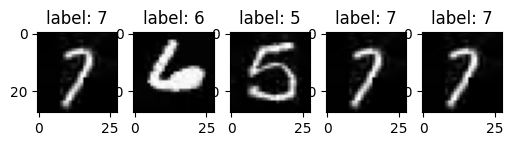

In [7]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[6,8])

df = response.batch.frames
for axi in ax.flat:
    idx = np.random.randint(len(df))
    img = df['mnistvid.data'].iloc[idx]
    label = df['mnistcnn.label'].iloc[idx]
    axi.imshow(img)
    
    axi.set_title(f'label: {label}')

plt.show()